In [9]:
from backpack_predictor import prepare_data, target_encoding
from backpack_predictor.features import target, baseline_features, feature_list, cat_cols

%load_ext autoreload
%autoreload 2

from datetime import datetime
import time
import numpy as np
import pandas as pd
from scipy.stats import skew, chisquare, kruskal, ks_2samp, chi2_contingency

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import TargetEncoder

# import xgboost as xgb
import lightgbm as lgb

from optuna.integration import LightGBMPruningCallback #XGBoostPruningCallback, CatBoostPruningCallback
import optuna

import warnings
warnings.filterwarnings('ignore')

test_df = pd.read_csv(r'..//data//test.csv')
train_df = pd.read_csv(r'..//data//train.csv')
train_extra_df = pd.read_csv(r'..//data//training_extra.csv')
train_df = pd.concat([train_df, train_extra_df], ignore_index=True)


# Apply function to train and test datasets
train_df = prepare_data(train_df, is_train=True)
test_df = prepare_data(test_df, is_train=False)

X = train_df.drop(target, axis=1)
y = train_df[target]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
feature_list = ['weight_capacity_te', 'brand', 'material', 'size', 'compartments', 'style', 'color', 'laptop_compartment', 'is_waterproof']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
data_splits = []

for train_index, val_index in kf.split(train_df):
    train_fold = train_df.iloc[train_index]
    val_fold = train_df.iloc[val_index]

    te = TargetEncoder(target_type="continuous", smooth=20)
    train_fold["weight_capacity_te"] = te.fit_transform(train_fold[["weight_capacity"]], train_fold[target])
    val_fold["weight_capacity_te"] = te.transform(val_fold[["weight_capacity"]])

    data_splits.append((train_fold, val_fold))

In [4]:
# kf = KFold(n_splits=3, shuffle=True, random_state=42)
# data_splits = []
# for fold, (train_index, test_index) in enumerate(kf.split(X), 1):

#     X_train, X_val = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[test_index]

#     X_train, X_val = preprocess_weight_capacity(pd.concat([X_train, y_train], axis=1), X_val)

#     X_train, X_val, encoded_cols = target_encoding(
#         train_df=X_train,
#         cat_cols=cat_cols,
#         test_df=X_val, 
#         target=y_train.name,
#     )
#     # X_train = X_train.drop(columns=[target])

#     data_splits.append(
#         (X_train, 
#         pd.concat([X_val[feature_list], y_val], axis=1))
#     )

In [5]:
model_str = "lgb_"

In [ ]:
def objective(trial):
    params = {
        'random_state': 42,
        'early_stopping_rounds': 50, # the {n}th accuracy on the validation set does not improve, stop training
        'verbose': -1,  # -1: Fatal, 0: Warning, 1: Info, 2: Debug
        'objective': 'regression',
        'metric': 'rmse',
        'force_row_wise': True,

        # bagging_fraction is like feature_fraction, but randomly selects data without resampling
        # bagging_freq must be non-zero to enable bagging
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),

        # default = 10.0,  used for the categorical features
        'cat_l2':  trial.suggest_float('cat_l2', 0.01, 20),

        # if set to true, when evaluating node splits LightGBM will check only one randomly-chosen threshold for each feature
        'extra_trees': trial.suggest_categorical("extra_trees", [True, False]),

        # subset of features on each iteration (tree) to select
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        # colsample_bytree is ignored when feature_fraction is set
        # 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.25, 0.35),

        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05, log=True),

        # max number of bins that feature values will be bucketed in
        'max_bin': trial.suggest_int('max_bin', 1, 10000),

        # <= 0 means no limit. Used to deal with over-fitting when data is small. Tree still grows leaf-wise. 
        'max_depth': trial.suggest_int('max_depth', -1, 1000),  

        # Very important to prevent over-fitting. Setting it to hundreds or thousands is enough for a large dataset.
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 100),
        'min_split_gain': 0.5,
        
        'n_estimators': trial.suggest_int('n_estimators', 10, 15000),

        # main parameter to control the complexity of the tree model. Should be smaller than 2^max_depth
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),

        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),

        # subsample is ignored when bagging_fraction is set
        # 'subsample': trial.suggest_float('subsample', 0.2, 0.25),
        
    }


    rmse_list = []
    for i, (train_fold, valid_fold) in enumerate(data_splits, 1):

        train_data = lgb.Dataset(train_fold[feature_list], label=train_fold[target])
        valid_data = lgb.Dataset(valid_fold[feature_list], label=valid_fold[target], reference=train_data)
      
        model = lgb.train(
            params=params,
            train_set=train_data,
            valid_sets=[train_data, valid_data],
            valid_names=['train_0', 'valid_0'],
            callbacks=[
                LightGBMPruningCallback(trial, "rmse", valid_name="valid_0"),
                lgb.log_evaluation(-1)                   # Suppress training logs
            ]
        )
        y_pred = model.predict(valid_fold[feature_list], num_iteration=model.best_iteration)
        rmse = root_mean_squared_error(valid_fold[target], y_pred)
        rmse_list.append(rmse)

    return np.mean(rmse_list)

study = optuna.create_study(
        storage=f"sqlite:///..//optuna//{model_str}db.sqlite3",
        study_name=model_str + datetime.now().strftime("%Y-%m-%d_%H-%M"),
        direction="minimize"
)
study.optimize(objective, n_trials=500)

print("\n=========================")
print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.number)
print("Best value (RMSE):", study.best_trial.value)
print("Best hyperparameters:", study.best_trial.params)
best_params = study.best_trial.params
best_params["random_state"] = 42
best_params["verbose"] = 0
best_params["metric"] = "rmse"
best_params["force_row_wise"] = True

[I 2025-02-12 21:32:05,301] A new study created in RDB with name: lgb_2025-02-12_21-32
[I 2025-02-12 21:38:30,224] Trial 0 finished with value: 38.694235802529505 and parameters: {'bagging_fraction': 0.9306369493105067, 'bagging_freq': 2, 'cat_l2': 7.551697000677804, 'extra_trees': False, 'feature_fraction': 0.6363095671758482, 'learning_rate': 0.018435740816804796, 'max_bin': 8697, 'max_depth': 253, 'min_samples_leaf': 15, 'n_estimators': 1064, 'num_leaves': 95, 'lambda_l1': 0.00010146408836271889, 'lambda_l2': 0.012296089820832188}. Best is trial 0 with value: 38.694235802529505.
[I 2025-02-12 21:53:56,834] Trial 1 finished with value: 38.69821606950014 and parameters: {'bagging_fraction': 0.8294174481548935, 'bagging_freq': 1, 'cat_l2': 19.108688738550878, 'extra_trees': True, 'feature_fraction': 0.6980397808259541, 'learning_rate': 0.0192275349554815, 'max_bin': 5903, 'max_depth': 752, 'min_samples_leaf': 51, 'n_estimators': 1458, 'num_leaves': 134, 'lambda_l1': 0.03329609712080032


Number of finished trials: 500
Best trial: 35
Best value (RMSE): 38.69333109924226
Best hyperparameters: {'bagging_fraction': 0.9845855827369719, 'bagging_freq': 4, 'cat_l2': 15.56109518501091, 'extra_trees': False, 'feature_fraction': 0.7854276569810373, 'learning_rate': 0.049027872072879605, 'max_bin': 2602, 'max_depth': 920, 'min_samples_leaf': 10, 'n_estimators': 4023, 'num_leaves': 35, 'lambda_l1': 0.00512002046717473, 'lambda_l2': 3.014253881843341e-07}


In [8]:
best_params["metric"] = "rmse"

In [11]:
def objective(trial):
    params = {
        'random_state': 42,
        'early_stopping_rounds': 20, # the {n}th accuracy on the validation set does not improve, stop training
        'verbose': -1,  # -1: Fatal, 0: Warning, 1: Info, 2: Debug
        'objective': 'regression',
        'metric': 'rmse',

        # bagging_fraction is like feature_fraction, but randomly selects data without resampling
        # bagging_freq must be non-zero to enable bagging
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.8, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),

        # default = 10.0,  used for the categorical features
        # 'cat_l2':  trial.suggest_float('cat_l2', 0.01, 20),

        # if set to true, when evaluating node splits LightGBM will check only one randomly-chosen threshold for each feature
        # 'extra_trees': trial.suggest_categorical("extra_trees", [True, False]),

        # subset of features on each iteration (tree) to select
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        # colsample_bytree is ignored when feature_fraction is set
        # 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.25, 0.35),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05, log=True),

        # max number of bins that feature values will be bucketed in
        'max_bin': trial.suggest_int('max_bin', 1, 100000),

        # <= 0 means no limit. Used to deal with over-fitting when data is small. Tree still grows leaf-wise. 
        'max_depth': trial.suggest_int('max_depth', -1, 1000),  

        # Very important to prevent over-fitting. Setting it to hundreds or thousands is enough for a large dataset.
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 1000),
        'min_split_gain': 0.5,
        
        # 'n_estimators': trial.suggest_int('n_estimators', 10, 15000),
        'n_estimators': 200,

        # main parameter to control the complexity of the tree model. Should be smaller than 2^max_depth
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),

        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 1.0, log=True),

        # subsample is ignored when bagging_fraction is set
        # 'subsample': trial.suggest_float('subsample', 0.2, 0.25),
        
    }


    rmse_list = []
    for i, (train_fold, valid_fold) in enumerate(data_splits, 1):

        train_data = lgb.Dataset(train_fold[feature_list], label=train_fold[target])
        valid_data = lgb.Dataset(valid_fold[feature_list], label=valid_fold[target], reference=train_data)
      
        model = lgb.train(
            params=params,
            train_set=train_data,
            valid_sets=[train_data, valid_data],
            valid_names=['train_0', 'valid_0'],
            callbacks=[
                LightGBMPruningCallback(trial, "rmse", valid_name="valid_0"),
                lgb.log_evaluation(-1)                   # Suppress training logs
            ]
        )
        y_pred = model.predict(valid_fold[feature_list], num_iteration=model.best_iteration)
        rmse = root_mean_squared_error(valid_fold[target], y_pred)
        rmse_list.append(rmse)

    return np.mean(rmse_list)

study = optuna.create_study(
        storage=f"sqlite:///..//optuna//{model_str}db.sqlite3",
        study_name=model_str + datetime.now().strftime("%Y-%m-%d_%H-%M"),
        direction="minimize"
)
study.optimize(objective, n_trials=500)

print("\n=========================")
print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.number)
print("Best value (RMSE):", study.best_trial.value)
print("Best hyperparameters:", study.best_trial.params)
best_params = study.best_trial.params
best_params["random_state"] = 42
best_params["verbose"] = 0
best_params["metric"] = "rmse"
best_params['objective'] = 'regression'

[I 2025-02-10 16:12:57,048] A new study created in RDB with name: lgb_2025-02-10_16-12
[I 2025-02-10 16:14:29,880] Trial 0 finished with value: 38.881400057939125 and parameters: {'bagging_fraction': 0.840860690707638, 'bagging_freq': 4, 'feature_fraction': 0.4327437371672223, 'colsample_bytree': 0.27123178257561686, 'learning_rate': 0.01181218118543953, 'max_bin': 40397, 'max_depth': 314, 'min_samples_leaf ': 405, 'num_leaves': 95, 'lambda_l1': 7.104347070373837, 'lambda_l2': 6.756986444085797e-07, 'subsample': 0.2009042462404373}. Best is trial 0 with value: 38.881400057939125.
[I 2025-02-10 16:17:02,880] Trial 1 finished with value: 38.87563925301222 and parameters: {'bagging_fraction': 0.8100915026859583, 'bagging_freq': 1, 'feature_fraction': 0.8341978103915103, 'colsample_bytree': 0.299271275945817, 'learning_rate': 0.015175000960921125, 'max_bin': 51190, 'max_depth': 296, 'min_samples_leaf ': 248, 'num_leaves': 205, 'lambda_l1': 0.010176531803973233, 'lambda_l2': 1.0019447772714


Number of finished trials: 500
Best trial: 354
Best value (RMSE): 38.87162553462412
Best hyperparameters: {'bagging_fraction': 0.9780930785565459, 'bagging_freq': 5, 'feature_fraction': 0.8556426245335559, 'colsample_bytree': 0.31198557362738505, 'learning_rate': 0.04748156996966733, 'max_bin': 69779, 'max_depth': 665, 'min_samples_leaf ': 24, 'num_leaves': 148, 'lambda_l1': 0.0021556304294933115, 'lambda_l2': 0.05627364738597358, 'subsample': 0.23525313033189474}


In [63]:
best_params

{'bagging_fraction': 0.9780930785565459,
 'bagging_freq': 5,
 'feature_fraction': 0.8556426245335559,
 'learning_rate': 0.04748156996966733,
 'max_bin': 69779,
 'max_depth': 665,
 'num_leaves': 148,
 'lambda_l1': 0.0021556304294933115,
 'lambda_l2': 0.05627364738597358,
 'random_state': 42,
 'verbose': 0,
 'objective': 'regression',
 'min_samples_leaf': 24}

In [7]:
train_df

,brand,material,size,compartments,laptop_compartment,is_waterproof,style,color,weight_capacity,price
0,3,0,1,7,-1,-1,2,0,11.611723,112.15875
1,3,3,0,10,-1,-1,1,4,27.078537,68.88056
2,4,0,0,2,-1,-1,1,2,16.643760,39.17320
3,2,1,0,8,-1,-1,1,4,12.937220,80.60793
4,0,3,1,1,-1,-1,1,4,17.749338,86.02312
...,...,...,...,...,...,...,...,...,...,...
3994313,2,3,-1,3,-1,-1,1,5,28.098120,104.74460
3994314,1,0,0,10,-1,-1,2,5,17.379531,122.39043
3994315,3,3,2,10,-1,-1,0,2,17.037708,148.18470
3994316,1,3,-1,2,-1,-1,0,1,28.783339,22.32269


In [13]:
train_df_encoded, test_df_encoded = preprocess_weight_capacity(train_df, test_df)

train_df_encoded, test_df_encoded, encoded_cols = target_encoding(
    train_df=train_df_encoded,
    cat_cols=cat_cols,
    test_df=test_df_encoded, 
    target=target,
)

In [38]:
train_data = lgb.Dataset(train_df_encoded[feature_list], label=train_df_encoded[target])
model = lgb.train(params=best_params, train_set=train_data)

In [39]:
# best_params

In [33]:
# del best_params['eval_metric']

In [27]:

# best_params['min_samples_leaf'] = 24

In [35]:
quantiles = [0.1, 0.9]  # Lower and upper bounds
quantile_models = {}

for q in quantiles:
    quantile_params = best_params.copy()
    quantile_params.update({
        "objective": "quantile",
        "alpha": q
    })

    train_data = lgb.Dataset(train_df_encoded[feature_list], label=train_df_encoded[target]) 
    quantile_models[q] = lgb.train(params=quantile_params, train_set=train_data)

In [40]:
X_test = test_df_encoded[feature_list]

y_pred = model.predict(X_test)
y_lower = quantile_models[0.1].predict(X_test)
y_upper = quantile_models[0.9].predict(X_test)

# Print sample output
for i in range(5):
    print(f"Pred: {y_pred[i]:.2f}, Lower: {y_lower[i]:.2f}, Upper: {y_upper[i]:.2f}")

Pred: 81.86, Lower: 28.83, Upper: 134.78
Pred: 82.75, Lower: 29.19, Upper: 135.18
Pred: 82.41, Lower: 27.90, Upper: 136.48
Pred: 80.79, Lower: 29.13, Upper: 134.30
Pred: 78.58, Lower: 25.82, Upper: 133.87


In [47]:
quantile_width = y_upper - y_lower

results_df = pd.DataFrame({
    "y_pred": y_pred,
    "y_lower": y_lower,
    "y_upper": y_upper,
    "midpoint": (y_upper + y_lower) / 2,
    "quantile_width": quantile_width
})

results_df.sort_values(by="quantile_width", ascending=True)

,y_pred,y_lower,y_upper,midpoint,quantile_width
164459,40.794629,20.188331,96.596631,58.392481,76.408300
127511,45.020558,20.432004,97.763583,59.097794,77.331578
187325,40.921457,20.848764,103.836507,62.342635,82.987744
167616,40.962314,21.078594,106.160919,63.619756,85.082325
106540,52.789885,20.620531,105.713287,63.166909,85.092755
...,...,...,...,...,...
121583,91.360337,17.698150,142.676008,80.187079,124.977859
36044,113.610736,21.983540,147.442600,84.713070,125.459060
44639,86.131928,17.879055,143.760218,80.819636,125.881162
17915,105.529693,21.843741,148.751697,85.297719,126.907957


<Axes: xlabel='y_lower', ylabel='Count'>

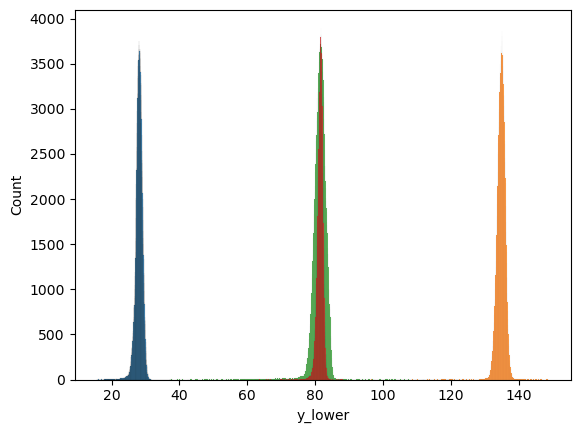

In [51]:
sns.histplot(results_df.y_lower)
sns.histplot(results_df.y_upper)
sns.histplot(results_df.y_pred, label='y_pred')
sns.histplot(results_df.midpoint, label='midpoint')

In [54]:
results_df.y_pred.mean(), results_df.y_pred.std()

(81.3754467345461, 2.1841610293828015)

In [56]:
results_df.midpoint.mean(), results_df.midpoint.std()

(81.48431038633113, 0.9113560742149481)

In [62]:
submit_path = f'..//submissions//' + model_str + datetime.now().strftime("%Y-%m-%d_%H-%M") + ".csv"
print("Saving to:", submit_path)
# y_pred.to_csv("submission.csv", index=False)

submit_df = test_df[['id']].copy()
submit_df['Price'] = results_df.midpoint
# submit_df['Price'] = np.mean(predictions, axis=0) # Average the predictions
submit_df.to_csv(submit_path, index=False)
# print(f"Submission file saved as submission.csv\n")
submit_df.head(5)

Saving to: ..//submissions//lgb_2025-02-10_19-59.csv


,id,Price
0,300000,81.805773
1,300001,82.185220
2,300002,82.193602
3,300003,81.716690
4,300004,79.843914


In [57]:
# Define a weight based on quantile width (higher width → more weight on upper)
weight = np.clip(quantile_width / quantile_width.max(), 0, 1)

# Adjust prediction using a blend of y_pred and y_upper
results_df["adjusted_pred"] = (1 - weight) * y_pred + weight * y_upper

In [59]:
weight

array([0.82942038, 0.82979378, 0.85001023, ..., 0.84304221, 0.8390487 ,
       0.82126352])

In [58]:
results_df

,y_pred,y_lower,y_upper,midpoint,quantile_width,adjusted_pred
0,81.855731,28.832035,134.779511,81.805773,105.947476,125.751793
1,82.752197,29.187633,135.182807,82.185220,105.995174,126.258791
2,82.413418,27.904823,136.482380,82.193602,108.577557,128.372589
3,80.793437,29.129325,134.304056,81.716690,105.174730,124.852521
4,78.579239,25.821316,133.866512,79.843914,108.045196,125.343569
...,...,...,...,...,...,...
199995,79.979490,28.106667,133.651492,80.879079,105.544825,124.326957
199996,78.953991,26.177099,134.103670,80.140385,107.926571,125.550723
199997,82.737569,28.362203,136.049688,82.205946,107.687485,127.681936
199998,81.791271,28.526647,135.704015,82.115331,107.177367,127.026689


In [19]:
results_df[results_df.y_pred != results_df.y_upper]

,y_pred,y_lower,y_upper,quantile_width


In [ ]:
# for i, (train_fold, valid_fold) in enumerate(data_splits, 1):

#     train_data = lgb.Dataset(train_fold[feature_list], label=train_fold[target])
#     valid_data = lgb.Dataset(valid_fold[feature_list], label=valid_fold[target], reference=train_data)
    
#     model = lgb.train(
#         params=best_params,
#         train_set=train_data,
#         valid_sets=[train_data, valid_data],
#         valid_names=['train_0', 'valid_0'],
#         callbacks=[
#             LightGBMPruningCallback(trial, "rmse", valid_name="valid_0"),
#             lgb.log_evaluation(-1)                   # Suppress training logs
#         ]
#     )
#     y_pred = model.predict(valid_fold[feature_list], num_iteration=model.best_iteration)
#     rmse = root_mean_squared_error(valid_fold[target], y_pred)
#     rmse_list.append(rmse)

# return np.mean(rmse_list)